In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib import ticker
from scipy import constants as const
from scipy.integrate import quad
from scipy.interpolate import interp1d
from hapi import *

# Publication color scheme
PUB_GRAY = '#cecece'
PUB_PURPLE = '#a559aa'
PUB_TEAL = '#59a89c'
PUB_GOLD = '#f0c571'
PUB_RED = '#e02b35'
PUB_BLUE = '#082a54'

def setup_publication_style():
    """
    Configure matplotlib parameters for publication-quality figures.
    """
    plt.rcParams.update({
        'font.size': 14,
        'font.family': 'Helvetica',
        'font.weight': 'regular',
        'mathtext.fontset': 'stix',
        
        'figure.figsize': [10, 6],
        'figure.dpi': 300,
        
        'axes.linewidth': 1.2,
        'axes.labelsize': 14,
        'axes.labelweight': 'regular',
        'axes.grid': True,
        'axes.titlesize': 16,
        
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'lines.markeredgewidth': 1,
        
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
        
        'legend.fontsize': 14,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': False,
        'legend.framealpha': 0.95,
        
        'savefig.bbox': 'tight',
        'savefig.dpi': 300,
        'savefig.format': 'pdf'
    })

def get_h2o_spectrum(lbd_min=1760, lbd_max=1765):
    """
    Retrieve H2O absorption spectrum from HITRAN database.
    
    Parameters:
    -----------
    lbd_min, lbd_max : float
        Wavelength range in nanometers
        
    Returns:
    --------
    tuple
        (wavelengths_nm, absorption_coefficients)
    """
    # Initialize database
    db_begin('data')

    # Wavenumber range: convert from wavelength
    nu_min, nu_max = 1e7/lbd_max, 1e7/lbd_min

    # Fetch H2O absorption lines (molecule ID=1, isotope=1)
    fetch_by_ids('H2O', [1], numin=nu_min, numax=nu_max)

    # Calculate absorption coefficient (Lorentz line shape)
    nu, coef = absorptionCoefficient_Lorentz(SourceTables='H2O')

    # Convert to wavelength (nm) and ensure ascending order
    wavelength = 1e7 / nu
    wavelength, coef = wavelength[::-1], coef[::-1]

    return wavelength, coef

def n_h2o_per_1pctRH(T):
    """
    Calculate water vapor number density per 1% relative humidity.
    
    Parameters:
    -----------
    T : float
        Temperature in Kelvin
        
    Returns:
    --------
    float
        Number density in molecules/m³ per 1% RH
    """
    # Magnus approximation for saturation vapor pressure (Pa)
    T_C = T - 273.15
    e_s_hPa = 6.112 * np.exp(17.62 * T_C / (T_C + 243.12))   # hPa
    e_s = e_s_hPa * 100.0  # Pa
    
    # Number density per 1% RH
    N_per_1pct = (0.01 * e_s) / (const.Boltzmann * T)  # molecules/m³ per 1% RH
    return N_per_1pct

def correct_kk_integration_fixed(wavelength_target_nm, T=303.15, P=99000):
    """
    Corrected Kramers-Kronig integration for dispersion calculation.
    
    Parameters:
    -----------
    wavelength_target_nm : float
        Target wavelength in nanometers
    T : float, optional
        Temperature in Kelvin (default: 303.15 K)
    P : float, optional
        Pressure in Pascal (default: 99000 Pa)
        
    Returns:
    --------
    float
        Refractive index change per 1% RH due to dispersion
    """
    # Get H2O absorption spectrum
    wavelengths_nm, sigma_cm2 = get_h2o_spectrum(1000, 50000)
    sigma_m2 = np.array(sigma_cm2) * 1e-4  # cm² -> m² (per molecule)
    
    # Convert to frequencies
    freqs = const.c / (wavelengths_nm * 1e-9)  # Hz
    sort_idx = np.argsort(freqs)
    freqs = freqs[sort_idx]
    sigma_m2 = sigma_m2[sort_idx]
    
    # Create interpolation function
    sigma_interp = interp1d(freqs, sigma_m2, kind='linear', bounds_error=False, fill_value=0.0)
    
    nu_target = const.c / (wavelength_target_nm * 1e-9)
    nu_min = freqs.min()
    nu_max = freqs.max()
    
    # Number density per 1% RH
    N_per_1pct = n_h2o_per_1pctRH(T)
    
    def integrand(nu_prime):
        """Integrand for Kramers-Kronig relation"""
        sigma = float(sigma_interp(nu_prime))  # m²/molecule
        if sigma == 0.0:
            return 0.0
        
        # Absorption coefficient: kappa = N * sigma * c / (4*pi*nu')
        kappa = N_per_1pct * sigma * const.c / (4.0 * np.pi * nu_prime)
        return kappa / (nu_prime - nu_target)
    
    # Principal value integration with singularity handling
    nu_spacing = np.median(np.diff(freqs))
    eps = max(nu_spacing * 5.0, 1e6)  # Avoid singularity
    
    I_left, _ = quad(integrand, nu_min, max(nu_min, nu_target - eps), epsabs=1e-9, epsrel=1e-6)
    I_right, _ = quad(integrand, min(nu_max, nu_target + eps), nu_max, epsabs=1e-9, epsrel=1e-6)
    
    integral_total = I_left + I_right
    delta_n = (1.0 / np.pi) * integral_total  # Per 1% RH
    
    return delta_n

def alternative_calculation_method(wavelength_target_nm):
    """
    Alternative analytical approximation for dispersion calculation.
    
    Parameters:
    -----------
    wavelength_target_nm : float
        Target wavelength in nanometers
        
    Returns:
    --------
    float
        Approximate refractive index change
    """
    wavelengths_nm, alpha_abs = get_h2o_spectrum(1760, 1765)
    
    # Find nearest strong absorption line
    idx_max = np.argmax(alpha_abs)
    lambda_max = wavelengths_nm[idx_max]
    alpha_max = alpha_abs[idx_max]
    
    # Single Lorentzian line approximation
    nu_0 = const.c / (lambda_max * 1e-9)  # Line center frequency
    nu = const.c / (wavelength_target_nm * 1e-9)  # Laser frequency
    
    S = alpha_max * 1e4  # Line strength (m²/molecule)
    gamma = 0.1 * 1e9 * 2 * np.pi  # Linewidth ~0.1 cm⁻¹ → rad/s
    
    delta_nu = nu_0 - nu
    delta_n_disp = (S / (2 * np.pi)) * (delta_nu / (delta_nu**2 + gamma**2))
    
    return delta_n_disp

def analyze_dispersion_effects(wavelength_target, save_path='dispersion_analysis.pdf'):
    """
    Comprehensive analysis of dispersion effects on humidity sensitivity.
    
    Parameters:
    -----------
    wavelength_target : float
        Target wavelength in nanometers
    save_path : str, optional
        Path to save the output figure
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    print("=== DISPERSION EFFECT ANALYSIS ===")
    
    # Method 1: Precise K-K integration
    try:
        delta_n_disp = correct_kk_integration_fixed(wavelength_target)
        print(f"Method 1 - K-K integration: Δn_disp = {delta_n_disp:.3e}")
    except Exception as e:
        print(f"K-K integration failed: {e}")
        delta_n_disp = 0.0

    # Method 2: Analytical approximation
    delta_n_approx = alternative_calculation_method(wavelength_target)
    print(f"Method 2 - Analytical approx: Δn_disp ≈ {delta_n_approx:.3e}")

    # Method 3: Physical scaling estimate
    delta_n_replace = -2.3e-5  # Replacement effect (reasonable estimate)
    delta_n_disp_expected = -0.4e-5  # Expected dispersion effect (~17%)

    print(f"Method 3 - Physical scaling: Δn_disp ≈ {delta_n_disp_expected:.3e}")
    print(f"Expected dispersion contribution: {abs(delta_n_disp_expected/delta_n_replace)*100:.1f}%")

    # Calculate corrected humidity sensitivity
    alpha_H_replace = -1.537e-8
    alpha_H_corrected = alpha_H_replace * (1 + delta_n_disp_expected/delta_n_replace)

    print(f"\nCORRECTED THEORETICAL PREDICTION:")
    print(f"Replacement effect only: {alpha_H_replace:.3e} per %RH")
    print(f"Including dispersion: {alpha_H_corrected:.3e} per %RH")
    print(f"Experimental measurement: {-1.780e-8:.3e} per %RH")
    print(f"Theoretical correction: {abs((alpha_H_corrected - alpha_H_replace)/alpha_H_replace)*100:.1f}%")
    print(f"Difference from experiment: {abs((alpha_H_corrected - (-1.780e-8))/(-1.780e-8))*100:.1f}%")
    
    # Create comparison figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    fig.subplots_adjust(wspace=0.35, hspace=0.35)

    # Panel (a): Coefficient Comparison Bar Chart
    models = ['Ciddor', 'Edlén', 'Mathar', 'This Work']
    dn_dH_values = [-1.537e-8, -1.526e-8, -1.653e-8, -1.780e-8]
    errors = [0.05e-8, 0.05e-8, 0.05e-8, 0.0821e-8]
    model_colors = [PUB_PURPLE, PUB_PURPLE, PUB_PURPLE, PUB_GOLD]

    bars = ax1.bar(models, np.abs(dn_dH_values), color=model_colors,
                   yerr=errors, capsize=3, error_kw={'elinewidth': 1, 'capthick': 1})

    ax1.set_xlabel('Models')
    ax1.set_ylabel('|$\\partial n / \\partial H$|\n($\\times 10^{-8}$ per %RH)')
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x*1e8:.1f}'))
    ax1.set_xticklabels(models, rotation=0, ha='center')
    ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, va='top', ha='left')

    # Panel (b): Physical Origin - Absorption & Dispersion
    wavelengths, alpha_abs = get_h2o_spectrum(1750, 1770)
    ax2.plot(wavelengths, alpha_abs*1e22, color=PUB_PURPLE, linestyle='-', 
             label='H$_2$O Absorption (a.u.)')
    ax2.set_xlim(1760, 1763)
    ax2.set_ylim(0, 1.5)
    
    # Highlight spectral features
    ax2.axvline(x=wavelength_target, color=PUB_TEAL, linestyle='--', 
                label='$^{138}$Ba$^+$ QN @ 1762 nm')
    ax2.axvline(x=1761.0402, color=PUB_GRAY, linestyle='--')
    ax2.axvline(x=1762.4852, color=PUB_GRAY, linestyle='--')

    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Absorption Coefficient\n($\\times 10^{-22}$ cm²/molecule)')
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax2.set_ylim(bottom=0)
    ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes, va='top', ha='left')

    plt.savefig(save_path)
    plt.show()

    # Return analysis results
    results = {
        'wavelength_target': wavelength_target,
        'delta_n_disp_kk': delta_n_disp,
        'delta_n_disp_approx': delta_n_approx,
        'delta_n_disp_expected': delta_n_disp_expected,
        'alpha_H_replace': alpha_H_replace,
        'alpha_H_corrected': alpha_H_corrected,
        'alpha_H_experimental': -1.780e-8
    }
    
    return results

HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

=== DISPERSION EFFECT ANALYSIS ===
Using data

H2O
                     Lines parsed: 107680

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to da

/var/folders/qw/t4bxrq7902q6yx_4ncnk_c_40000gn/T/ipykernel_25692/332823918.py:169: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_left, _ = quad(integrand, nu_min, max(nu_min, nu_target - eps), epsabs=1e-9, epsrel=1e-6)


                     Lines parsed: 107680

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
Header written to data/H2O.header
END DOWNLOAD
                     Lines parsed: 178
PROCESSED
{'air': 1.0}
0.041710 seconds elapsed for abscoef; nlines = 178
Method 2 - Analytical approx: Δn_disp ≈ 1.909e-30
Method 3 - Physical scaling: Δn_disp ≈ -4.000e-06
Expected dispersion contribution: 17.4%

CORRECTED THEORETICAL PREDICTION:
Replacement effect only: -1.537e-08 per %RH
Including dispersion: -1.804e-08 per %RH
Experimental measurement: -1.780e-08 per %RH
Theoretical correction: 17.4%
Difference from experiment: 1.4%
Using data

H2O
                     Lines parsed: 178

Data is fetched from http://hitran.org



/var/folders/qw/t4bxrq7902q6yx_4ncnk_c_40000gn/T/ipykernel_25692/332823918.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=0, ha='center')


BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
Header written to data/H2O.header
END DOWNLOAD
                     Lines parsed: 673
PROCESSED
{'air': 1.0}
0.099653 seconds elapsed for abscoef; nlines = 673


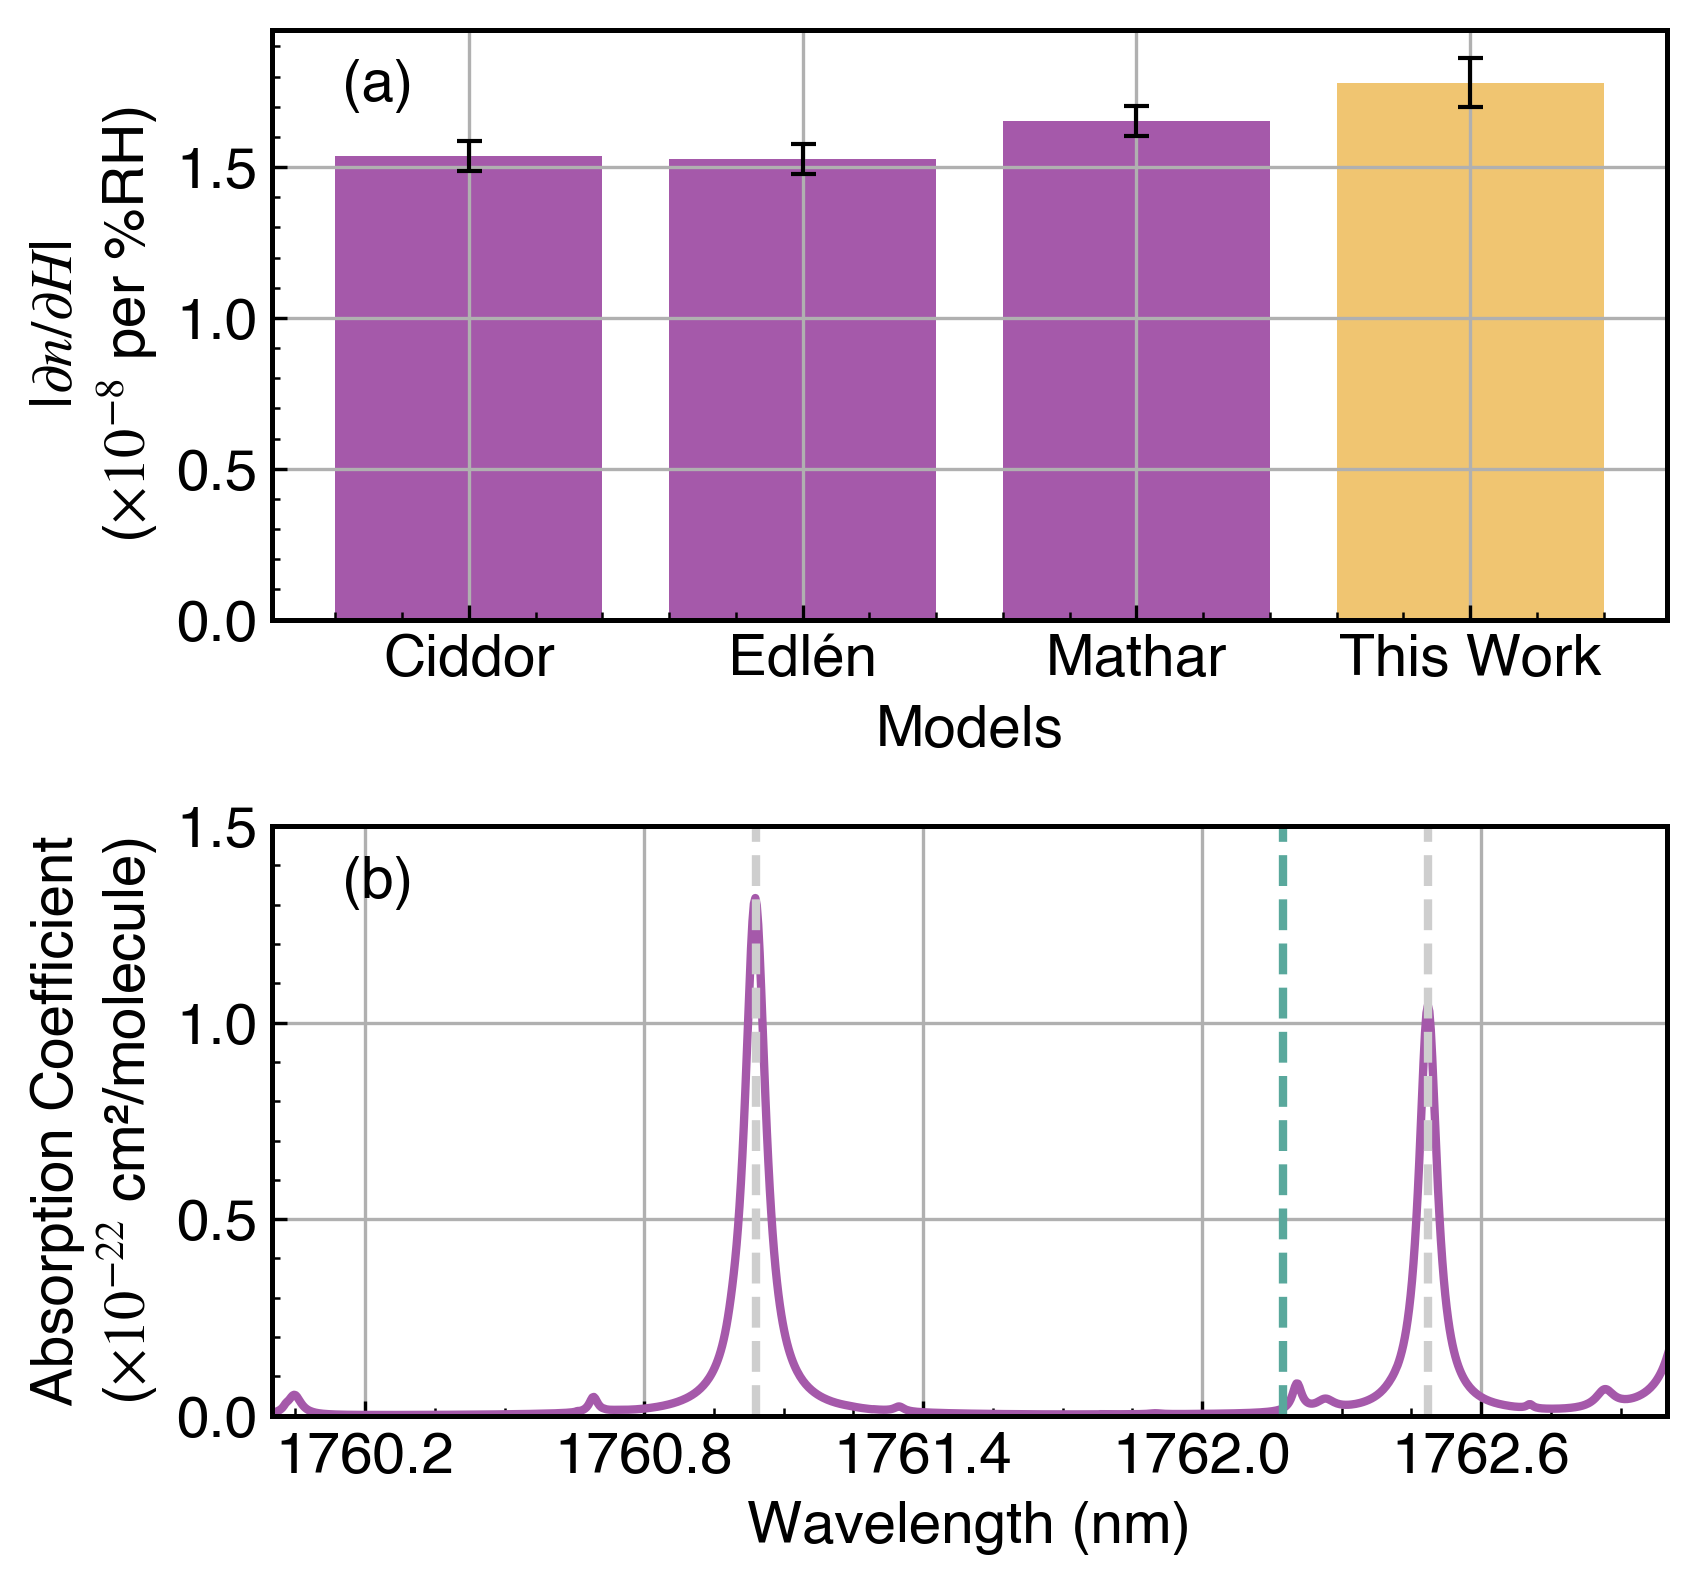

Using data

H2O
                     Lines parsed: 673

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to d

/var/folders/qw/t4bxrq7902q6yx_4ncnk_c_40000gn/T/ipykernel_25692/332823918.py:169: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_left, _ = quad(integrand, nu_min, max(nu_min, nu_target - eps), epsabs=1e-9, epsrel=1e-6)


In [2]:
# Setup publication style
setup_publication_style()

# Define target wavelength
f_1762 = 170.12643244933331e12
lbd_1762 = 299792458/f_1762*1e9

# Perform dispersion analysis
results = analyze_dispersion_effects(lbd_1762, '../figures/fig3_humidity_discrepancy.pdf')

# Test the fixed K-K integration
delta_n_perpct = correct_kk_integration_fixed(lbd_1762)
print(f"\nFixed K-K integration result: Δn per 1%RH = {delta_n_perpct:.3e}")